h= 1.0 

[1.+0.j]
[1.]


h= 0.5 

[1.+0.j]
[1.]


h= 0.25 



C:\Users\ramon\AppData\Local\Temp\ipykernel_12456\269453226.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  minEV[k] = lam_abs


[1.+0.j]
[1.]




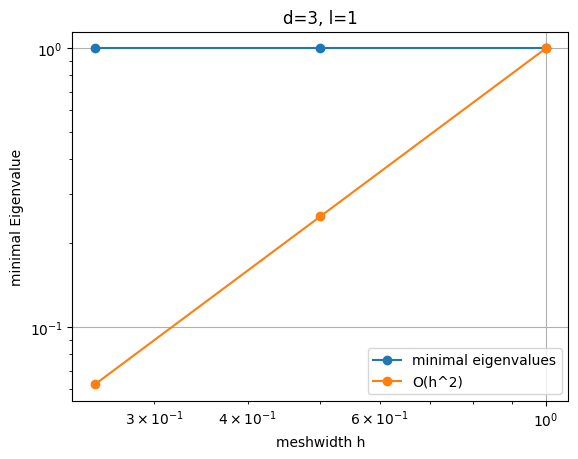

In [ ]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

meshwidths = np.array([1.0,0.5,0.25]) 
minEV = np.zeros(len(meshwidths))

k = 0

netgen_mesh =unit_cube.GenerateMesh(maxh=1)
mesh=Mesh(netgen_mesh)

for h in meshwidths:
    print("h=",h, "\n")
    #Draw(mesh)

    #set function space, curl type 1 function space has no order 0 (same as order 1)
    #type2 differs for order 0 / 1, and order = 0 has same # dofs as type 1 order 0 or 1
    H_h = Compress(HCurl(mesh, order = 1, type1=True, complex=True)) # main function space
    H_H = Compress(HCurl(mesh, order = 2, type1=True, complex=True)) # high order Function space for Riesz representative 
    
    
    #choose w_h and set its values on the nodes
    # w = (exp(2j * z),0,0)

    # w_h = GridFunction(H_h) #set the nodes
    # w_h.Set(w)

    # f_H = GridFunction(H_H, name="f_H") #high order 

    #low order trial and test function
    u_h = H_h.TrialFunction() 
    v_h = H_h.TestFunction() 
    #High order trial and test function
    u_H = H_H.TrialFunction() 
    v_H= H_H.TestFunction() 

    m = BilinearForm(H_h) #define m with the L2 inner product on the low order space
    m += u_h*v_h * dx 
    m.Assemble()

    a = BilinearForm(H_H) # define the H(curl) inner product on the high order space
    a += curl(u_H) * curl(v_H) * dx
    a += u_H*v_H * dx 
    a.Assemble()

    #mass matrix with mixed basis functions
    a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
    a_mixed += u_h*v_H*dx
    a_mixed.Assemble()

    #not necessary for correct experiment
    # a_dest = BilinearForm(H_H)
    # a_dest += u_H*v_H*dx
    # a_dest.Assemble()

    # t = a_dest.mat.Inverse() @ a_mixed.mat

    #w_H is the high order embedding of w_h
    # w_H = GridFunction(H_H, name="w_H")
    # w_H.vec.data = t * w_h.vec

    #compute inverses 
    a_inv = a.mat.Inverse(freedofs=H_H.FreeDofs())

    m_inv = m.mat.Inverse(freedofs=H_h.FreeDofs())

    #solve for the riesz representative (f_H) 
    # temp = f_H.vec.CreateVector()
    # temp.data = m.mat * w_H.vec
    # f_H.vec.data = a_inv * temp

    #create Matrices for GEV problem

    #c is the low order galerkin matrix
    c = BilinearForm(H_h)
    c += curl(u_h) * curl(v_h) * dx
    c += u_h*v_h * dx 
    c.Assemble()

    #check norms
    # temp3 = c.mat * w_h.vec
    # w_h_norm = w_h.vec.InnerProduct(temp3)
    # print("H(div) norm of w_h:", sqrt(w_h_norm)) #norm of w_h in H(div,

    # temp4 = a.mat * f_H.vec
    # f_H_norm = f_H.vec.InnerProduct(temp4)
    # print("H(div) norm of f_H, the riesz representative of w_h:", sqrt(f_H_norm)) #norm of the riesz representative

    #faster, but might give problems
    # m==m.t
    b = c.mat.T @m_inv.T @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_inv @ c.mat
    B = b.ToDense().NumPy()

    C = c.mat.ToDense().NumPy()
    
    #For dense calc in Numpy
    # M = m.mat.ToDense().NumPy()
    # A_inv = a_inv.ToDense().NumPy()
    # T = t.ToDense().NumPy()

    # #M == M.T 
    # B = T.T @ M.T @ A_inv @ M @ T

    EV = sp.sparse.linalg.eigs(C, k=1, M=B, which='SM', return_eigenvectors=False)
    print(EV)
    lam_abs = np.abs(EV)
    print(lam_abs)
    minEV[k] = lam_abs

    #iteration update
    k = k + 1
    #uniformly refines mesh, halving meshwidth
    mesh.Refine()
    print("\n")

fig, ax = plt.subplots()
plt.grid(visible=True)
plt.loglog(meshwidths,minEV, 'o-', label="minimal eigenvalues")
plt.loglog(meshwidths,np.power(meshwidths,2),'o-', label="O(h^2)")
# plt.loglog(meshwidths,np.power(meshwidths,3),'o-', label="O(h^3)")
# plt.loglog(meshwidths,np.power(meshwidths,4),'o-', label="O(h^4)")
plt.xlabel('meshwidth h')
plt.ylabel('minimal Eigenvalue')
plt.title('d=3, l=1')
plt.legend()
plt.show()
